Bronnen:

- https://www.geeksforgeeks.org/python-word-embedding-using-word2vec/
- https://github.com/BIJOY-SUST/Binary-Text-Classification--Word2vec-SVM/blob/master/notebook/word2vec%2Bsvm.ipynb
- https://www.youtube.com/watch?v=Z1VsHYcNXDI
- https://stackoverflow.com/questions/70897154/how-to-fit-word2vec-on-test-data # Inspiration for the key vec part
- https://medium.com/@dilip.voleti/classification-using-word2vec-b1d79d375381 # Most important for Word2Vec
- https://www.guru99.com/word-embedding-word2vec.html # For saving

In [1]:
import nltk # Used for preprocessing
import string # Used for preprocessing
import numpy as np # Used for saving
import pandas as pd # Used for dataframe
import matplotlib.pyplot as plt # For plotting the graphs
import seaborn as sns # For the confusion matrix

from nltk.corpus import stopwords # Used for preprocessing
from nltk.stem   import WordNetLemmatizer # Used for preprocessing
from nltk.tokenize import word_tokenize # Used for preprocessing
from sklearn.model_selection import train_test_split # Used for splitting the data

from sklearn.model_selection import GridSearchCV # Used for tuning
from sklearn.svm import SVC # Used for SVM modeling
from sklearn.model_selection import cross_validate # Used for cross-validation
from sklearn.metrics import classification_report # Used for model evaluation
from sklearn.metrics import confusion_matrix # Used for confusion matrix

from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
import gensim
from gensim.models import Word2Vec
import joblib # For saving the model

In [2]:
# Loading the dataset

df = pd.read_csv('WELFake_Dataset.csv', index_col = 0)
df = df.dropna()

In [3]:
# Specyfing X and y

X = df['text']
y = df['label']

In [4]:
# Preprocessing

def preprocess_text(text):
    text = ''.join([c for c in text if c not in string.punctuation and c not in string.digits])
    tokens = word_tokenize(text, 'english')
    lowered = [x.lower() for x in tokens] # new
    lemmatiser = WordNetLemmatizer()
    lemmatized = [lemmatiser.lemmatize(word) for word in lowered] # Adjusted
    sw = stopwords.words('english')
    stopped = [word for word in lemmatized if word.lower() not in sw]
    return stopped

In [5]:
# Preprocessing all articles

data = []
for i in X[:]:
    data.append(preprocess_text(i))

KeyboardInterrupt: 

In [ ]:
from gensim.models.callbacks import CallbackAny2Vec

class callback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        print('Loss after epoch {}: {}'.format(self.epoch, loss))
        self.epoch += 1

model_Word2Vec = Word2Vec(data, sg = 1, min_count = 1, vector_size = 300, 
                          window = 5, workers = 4, epochs = 50, compute_loss = True, callbacks=[callback()])

# Testing the vocabulary

In [ ]:
print("Cosine similarity between 'comment' " +
               "and 'announcement' - CBOW : ",
    model_Word2Vec.wv.similarity('comment', 'announcement'))

In [ ]:
model_Word2Vec.wv.most_similar('comment')

In [ ]:
model_Word2Vec.wv['comment']

In [ ]:
model_Word2Vec.save("model_Word2Vec_trained")

# Embedding the data

In [9]:
model_Word2Vec = Word2Vec.load('model_Word2Vec_trained')

In [10]:
key_index = model_Word2Vec.wv.key_to_index    # This indexes all the words in the in the dictionary. 
                                        # Not sure if this is needed.

In [11]:
words = set(model_Word2Vec.wv.index_to_key ) # These are all unique words in the dictionary

In [12]:
# Splitting the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [13]:
# Preprocessing all articles

X_train_pre = []
for i in X_train[:]:
    X_train_pre.append(preprocess_text(i))

In [ ]:
X_train_vect = np.array([np.array([model_Word2Vec.wv[i] for i in ls if i in words])for ls in X_train_pre[:]])

In [ ]:
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(32, dtype=float))

In [ ]:
print(X_train_vect_avg[0])

In [ ]:
joblib.dump(X_train_vect_avg,'/Users/pietervanbrakel/Thesis/SVM_W2V_train_vector_2_new.pkl',compress=3)

In [ ]:
X_train_vect_avg = joblib.load('/Users/pietervanbrakel/Thesis/SVM_W2V_train_vector_2_new.pkl')

In [ ]:
svm = SVC()
scores = cross_validate(svm, X_train_vect_avg, y_train.ravel(), scoring=['f1', 'accuracy'], cv=5, n_jobs=-1) # Scoring the training

In [ ]:
pd.DataFrame(scores).describe()

# Tuning

In [ ]:
# defining parameter range
param_grid = {'kernel': ('rbf', 'linear', 'sigmoid'),
              'C': [0.001, 0.01, 0.1, 1, 10, 100], 
              'gamma': [100, 10, 1, 0.1, 0.01, "Scale"]} 
  
grid = GridSearchCV(svm, param_grid, refit = True, cv = 2, verbose = 3)
  
# fitting the model for grid search
grid.fit(X_train_vect_avg, y_train.ravel())

# print best parameter after tuning
print(grid.best_params_)
print("\n")

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

# Training

In [67]:
svm = SVC(C = 10, gamma = 0.1, kernel = 'rbf') # Initializing the model
svm.fit(X_train_vect_avg, y_train.ravel()) # Training the model with the Y train data and X feature extraction data

SVC(C=10, gamma=0.1)

In [99]:
joblib.dump(svm,'/Users/pietervanbrakel/Thesis/SVM_W2V_2.pkl',compress=3)

['/Users/pietervanbrakel/Thesis/SVM_W2V_2.pkl']

# Test data

In [23]:
svm = joblib.load('/Users/pietervanbrakel/Thesis/SVM_W2V_2.pkl')

In [68]:
X_test_pre = []
for i in X_test[:]:
    X_test_pre.append(preprocess_text(i))

In [69]:
X_test_vect = np.array([np.array([model_Word2Vec.wv[i] for i in ls if i in words])for ls in X_test_pre[:]])

<ipython-input-69-bca54af406a0>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_vect = np.array([np.array([model_Word2Vec.wv[i] for i in ls if i in words])for ls in X_test_pre[:]])


In [70]:
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(32, dtype=float))

In [26]:
# joblib.dump(X_test_vect_avg,'/Users/pietervanbrakel/Thesis/SVM_W2V_test_vector_2.pkl',compress=3)

['/Users/pietervanbrakel/Thesis/SVM_W2V_test_vector.pkl']

In [27]:
# X_test_vect_avg = joblib.load('/Users/pietervanbrakel/Thesis/SVM_W2V_test_vector_2.pkl')

In [71]:
y_pred = svm.predict(X_test_vect_avg)

In [76]:
pd.DataFrame(classification_report(y_test, y_pred, output_dict = True))

,0,1,accuracy,macro avg,weighted avg
precision,0.944397,0.942834,0.943598,0.943615,0.943601
recall,0.940498,0.946588,0.943598,0.943543,0.943598
f1-score,0.942443,0.944707,0.943598,0.943575,0.943596
support,7025.000000,7283.000000,0.943598,14308.000000,14308.000000


# Split confusion matrix

In [77]:
df = pd.read_csv('WELFake_Dataset.csv', index_col = 0)

In [78]:
df_kaggle = df.loc[:20799]
df_McIntire = df.loc[20800:27134]
df_Reuters = df.loc[27135:72032]
df_Buzzfeed = df.loc[72033:]

df_kaggle = df_kaggle.dropna()
df_McIntire = df_McIntire.dropna()
df_Reuters = df_Reuters.dropna()
df_Buzzfeed = df_Buzzfeed.dropna()

In [79]:
print("Nr. of news articles in Kaggle :", len(df_kaggle))
print("Nr. of news articles in McIntire :", len(df_McIntire))
print("Nr. of news articles in Reuters :", len(df_Reuters))
print("Nr. of news articles in Buzzfeed :", len(df_Buzzfeed))

Nr. of news articles in Kaggle : 20664
Nr. of news articles in McIntire : 6285
Nr. of news articles in Reuters : 44487
Nr. of news articles in Buzzfeed : 101


In [80]:
df_kaggle_y = df_kaggle.iloc[:, 2]
df_kaggle_x = df_kaggle.iloc[:, 1]
df_McIntire_y = df_McIntire.iloc[:, 2]
df_McIntire_x = df_McIntire.iloc[:, 1]
df_Reuters_y = df_Reuters.iloc[:, 2]
df_Reuters_x = df_Reuters.iloc[:, 1]
df_Buzzfeed_y = df_Buzzfeed.iloc[:, 2]
df_Buzzfeed_x = df_Buzzfeed.iloc[:, 1]

### Kaggle sub-dataset

In [87]:
X_kaggle_pre = []
for i in df_kaggle_x[:]:
    X_kaggle_pre.append(preprocess_text(i))
    
X_kaggle_vect = np.array([np.array([model_Word2Vec.wv[i] for i in ls if i in words])for ls in X_kaggle_pre[:]])

X_kaggle_vect_avg = []
for v in X_kaggle_vect:
    if v.size:
        X_kaggle_vect_avg.append(v.mean(axis=0))
    else:
        X_kaggle_vect_avg.append(np.zeros(32, dtype=float))

<ipython-input-87-ca3a12d9474f>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_kaggle_vect = np.array([np.array([model_Word2Vec.wv[i] for i in ls if i in words])for ls in X_kaggle_pre[:]])


In [88]:
kaggle_y_pred = svm.predict(X_kaggle_vect_avg)

In [89]:
pd.DataFrame(classification_report(df_kaggle_y, kaggle_y_pred, output_dict = True))

,0,1,accuracy,macro avg,weighted avg
precision,0.966794,0.964386,0.965544,0.965590,0.965550
recall,0.961762,0.969084,0.965544,0.965423,0.965544
f1-score,0.964271,0.966729,0.965544,0.965500,0.965541
support,9990.000000,10674.000000,0.965544,20664.000000,20664.000000


Text(51.0, 0.5, 'Real Labels')

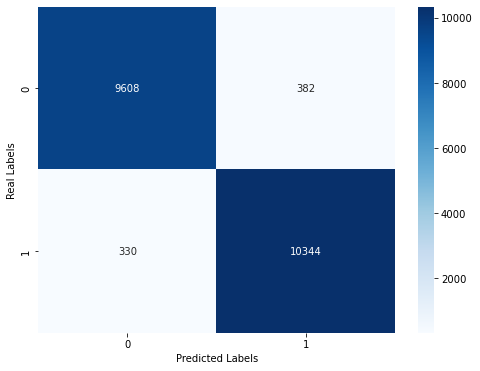

In [90]:
# plot the confusion matrix
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(df_kaggle_y, kaggle_y_pred), annot=True, fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

### McIntire sub-dataset

In [91]:
X_McIntire_pre = []
for i in df_McIntire_x[:]:
    X_McIntire_pre.append(preprocess_text(i))
    
X_McIntire_vect = np.array([np.array([model_Word2Vec.wv[i] for i in ls if i in words])for ls in X_McIntire_pre[:]])

X_McIntire_vect_avg = []
for v in X_McIntire_vect:
    if v.size:
        X_McIntire_vect_avg.append(v.mean(axis=0))
    else:
        X_McIntire_vect_avg.append(np.zeros(32, dtype=float))
        
McIntire_y_pred = svm.predict(X_McIntire_vect_avg)
        
pd.DataFrame(classification_report(df_McIntire_y, McIntire_y_pred, output_dict = True))

<ipython-input-91-e898b9b31a78>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_McIntire_vect = np.array([np.array([model_Word2Vec.wv[i] for i in ls if i in words])for ls in X_McIntire_pre[:]])


,0,1,accuracy,macro avg,weighted avg
precision,0.962270,0.961384,0.961814,0.961827,0.961815
recall,0.959124,0.964363,0.961814,0.961743,0.961814
f1-score,0.960694,0.962871,0.961814,0.961783,0.961812
support,3058.000000,3227.000000,0.961814,6285.000000,6285.000000


Text(51.0, 0.5, 'Real Labels')

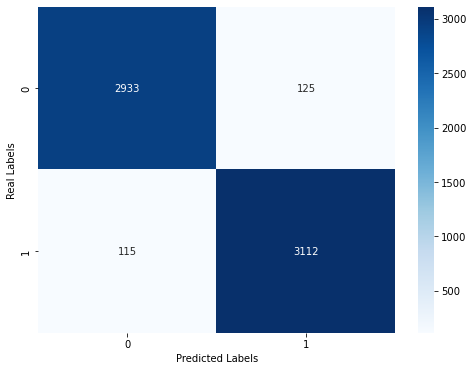

In [92]:
# plot the confusion matrix
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(df_McIntire_y, McIntire_y_pred), annot=True, fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

### Reuters sub-dataset

In [93]:
X_Reuters_pre = []
for i in df_Reuters_x[:]:
    X_Reuters_pre.append(preprocess_text(i))
    
X_Reuters_vect = np.array([np.array([model_Word2Vec.wv[i] for i in ls if i in words])for ls in X_Reuters_pre[:]])

X_Reuters_vect_avg = []
for v in X_Reuters_vect:
    if v.size:
        X_Reuters_vect_avg.append(v.mean(axis=0))
    else:
        X_Reuters_vect_avg.append(np.zeros(32, dtype=float))
        
Reuters_y_pred = svm.predict(X_Reuters_vect_avg)
        
pd.DataFrame(classification_report(df_Reuters_y, Reuters_y_pred, output_dict = True))

<ipython-input-93-ba909220626a>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_Reuters_vect = np.array([np.array([model_Word2Vec.wv[i] for i in ls if i in words])for ls in X_Reuters_pre[:]])


,0,1,accuracy,macro avg,weighted avg
precision,0.965918,0.962528,0.964192,0.964223,0.964200
recall,0.961295,0.967010,0.964192,0.964152,0.964192
f1-score,0.963601,0.964764,0.964192,0.964182,0.964190
support,21935.000000,22552.000000,0.964192,44487.000000,44487.000000


Text(51.0, 0.5, 'Real Labels')

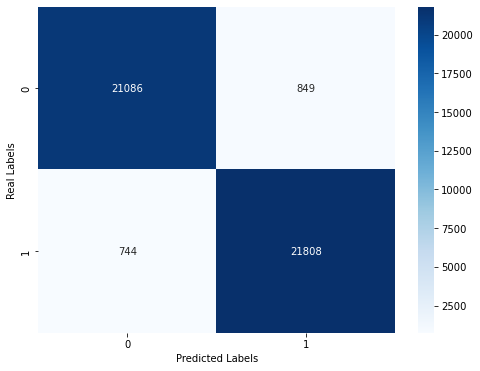

In [94]:
# plot the confusion matrix
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(df_Reuters_y, Reuters_y_pred), annot=True, fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

### Buzzfeed sub-dataset

In [95]:
X_Buzzfeed_pre = []
for i in df_Buzzfeed_x[:]:
    X_Buzzfeed_pre.append(preprocess_text(i))
    
X_Buzzfeed_vect = np.array([np.array([model_Word2Vec.wv[i] for i in ls if i in words])for ls in X_Buzzfeed_pre[:]])

X_Buzzfeed_vect_avg = []
for v in X_Buzzfeed_vect:
    if v.size:
        X_Buzzfeed_vect_avg.append(v.mean(axis=0))
    else:
        X_Buzzfeed_vect_avg.append(np.zeros(32, dtype=float))
        
Buzzfeed_y_pred = svm.predict(X_Buzzfeed_vect_avg)
        
pd.DataFrame(classification_report(df_Buzzfeed_y, Buzzfeed_y_pred, output_dict = True))

<ipython-input-95-53375ad53e1d>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_Buzzfeed_vect = np.array([np.array([model_Word2Vec.wv[i] for i in ls if i in words])for ls in X_Buzzfeed_pre[:]])


,0,1,accuracy,macro avg,weighted avg
precision,0.976744,0.948276,0.960396,0.962510,0.960960
recall,0.933333,0.982143,0.960396,0.957738,0.960396
f1-score,0.954545,0.964912,0.960396,0.959729,0.960293
support,45.000000,56.000000,0.960396,101.000000,101.000000


Text(51.0, 0.5, 'Real Labels')

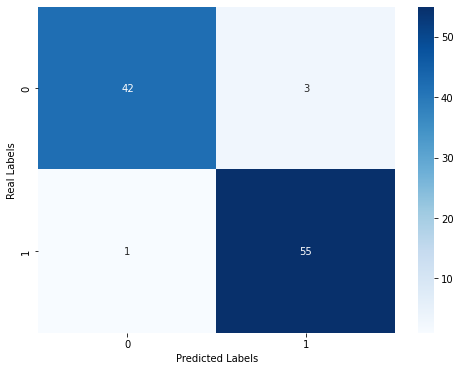

In [96]:
# plot the confusion matrix
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(df_Buzzfeed_y, Buzzfeed_y_pred), annot=True, fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')